In [1]:
library(CausalImpact)
library(ggplot2)
library(missForest)
library(zoo)
library(gridExtra)
t <- seq.Date(as.Date("1984-07-01"), by = "years", length.out = 30)

Loading required package: bsts

Loading required package: BoomSpikeSlab

Loading required package: Boom




Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: xts


Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn




### Read Data

In [3]:
require("reticulate")
source_python("pickle_reader.py")

# Pixels where there was a significant change in land cover in 1994
ndvi_1994_mean <- read_pickle_file("../../working/ndvi_changed_mean_1994")

Loading required package: reticulate



### Implement causal analyses on every NDVI trend in disturbed pixels

In [4]:
set.seed(123)
res=matrix(,nrow=length(ndvi_1994_data),ncol=5)
res2=matrix(,nrow=length(ndvi_1994_data),ncol=5)
y=matrix(NA,nrow=30,ncol=length(ndvi_1994_data))
X=matrix(NA,nrow=30,ncol=length(ndvi_1994_data))

for(k in 1:length(ndvi_1994_data)){
# for(k in 1:5){
    print(k)
    flush.console()
    tryCatch({
        data=ndvi_1994_data[k]
        data<-matrix(unlist(data),nrow=30)
        # all_columns_na <- apply(data, 1, function(row) all(is.na(row)))
        # t_na_rm = t[all_columns_na==FALSE]
        # data_na_rm = data[all_columns_na==FALSE,]
        imputed_data<-missForest(data)
        imputed_data<-imputed_data[1]$ximp

        # data_ts <- zoo(imputed_data, t)
        # ave = rowMeans(data_ts[,2:dim(data_ts)[2]],1)
        y[,k] <- imputed_data[,1]
        X[,k] = rowMeans(imputed_data[,2:dim(imputed_data)[2]],1)
        data_ts_ave = zoo(cbind(y[,k],X[,k]),t)
        pre.period <- as.Date(c("1984-07-01", "1993-07-01"))
        post.period <- as.Date(c("1994-07-01", "2013-07-01"))
        impact <- CausalImpact(data_ts_ave, pre.period, post.period)
        # impact2 <- CausalImpact(data_ts, pre.period, post.period)

        res[k,1] = impact$summary$Actual[1]
        res[k,2] = impact$summary$Pred[1]
        res[k,3] = impact$summary$AbsEffect[1]
        res[k,4] = impact$summary$RelEffect[1]
        res[k,5] = impact$summary$p[1]},
        
    error=function(err){return(NA)})
}

ERROR: Error in eval(expr, envir, enclos): object 'ndvi_1994_data' not found


Take the mean of all NDVI in disturbed pixels (y) and not-disturnbed pixels (X)

In [ ]:
y_mean = rowMeans(y,na.rm=TRUE)
X_mean = rowMeans(X,na.rm=TRUE)
data_mean = zoo(cbind(y_mean,X_mean),t)
save(res, data_mean, file = "../working/ci_results_data.RData")

In [2]:
load("../../working/ci_results_data.RData")

Posterior inference {CausalImpact}

                         Average           Cumulative     
Actual                   0.56              11.24          
Prediction (s.d.)        0.59 (0.0047)     11.83 (0.0934) 
95% CI                   [0.58, 0.6]       [11.65, 12.0]  
                                                          
Absolute effect (s.d.)   -0.03 (0.0047)    -0.59 (0.0934) 
95% CI                   [-0.039, -0.02]   [-0.780, -0.41]
                                                          
Relative effect (s.d.)   -5% (0.75%)       -5% (0.75%)    
95% CI                   [-6.5%, -3.5%]    [-6.5%, -3.5%] 

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.89889%

For more details, type: summary(impact, "report")

NULL


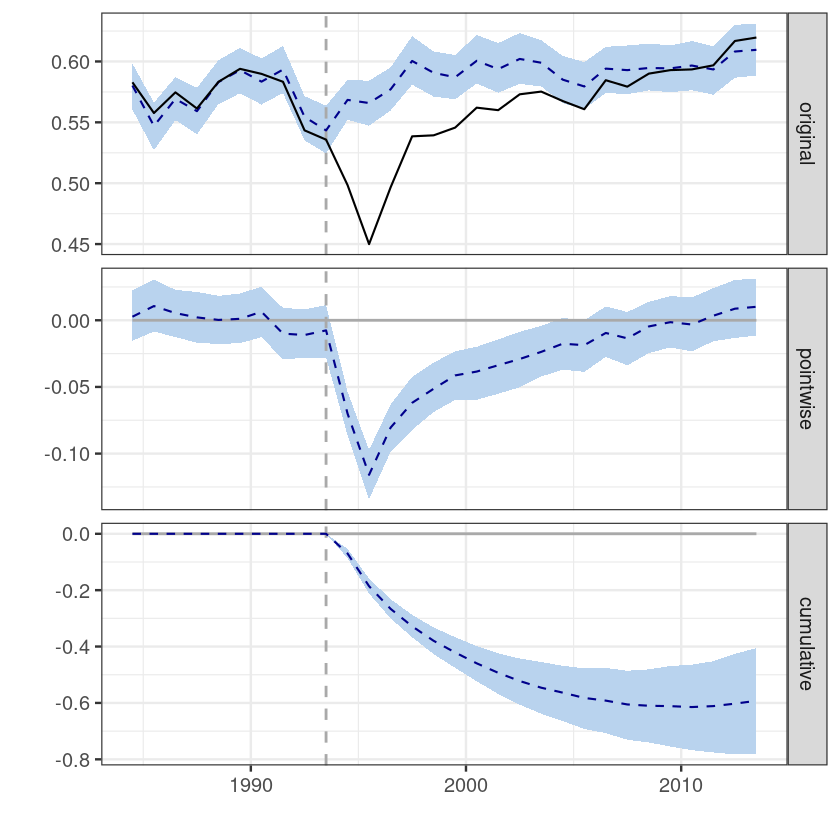

In [3]:
set.seed(1)
pre.period <- as.Date(c("1984-07-01", "1993-07-01"))
post.period <- as.Date(c("1994-07-01", "2013-07-01"))
ci <- CausalImpact(data_mean, pre.period, post.period)
plot(ci)
print(summary(ci))

In [5]:
infer <- ci$series

In [6]:
pred <- infer$point.pred
response <- infer$response
point.effect <- infer$point.effect 
point.effect.lower <- infer$point.effect.lower
point.effect.upper <- infer$point.effect.upper
pred.lower <- infer$point.pred.lower
pred.upper <- infer$point.pred.upper
data = data.frame(pred,pred.lower,pred.upper)

In [14]:
I <-  which((response[11:length(response)]>mean(response[1:10]))==TRUE)[1]
rec1 = response[11:length(response)][I]

2002-07-01 
 0.5730251 

Warning message in annotate("text", x = as.Date("1987-07-01"), y = 0.45, label = "Distrubance(1994)", :
“Ignoring unknown parameters: `face`”
Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

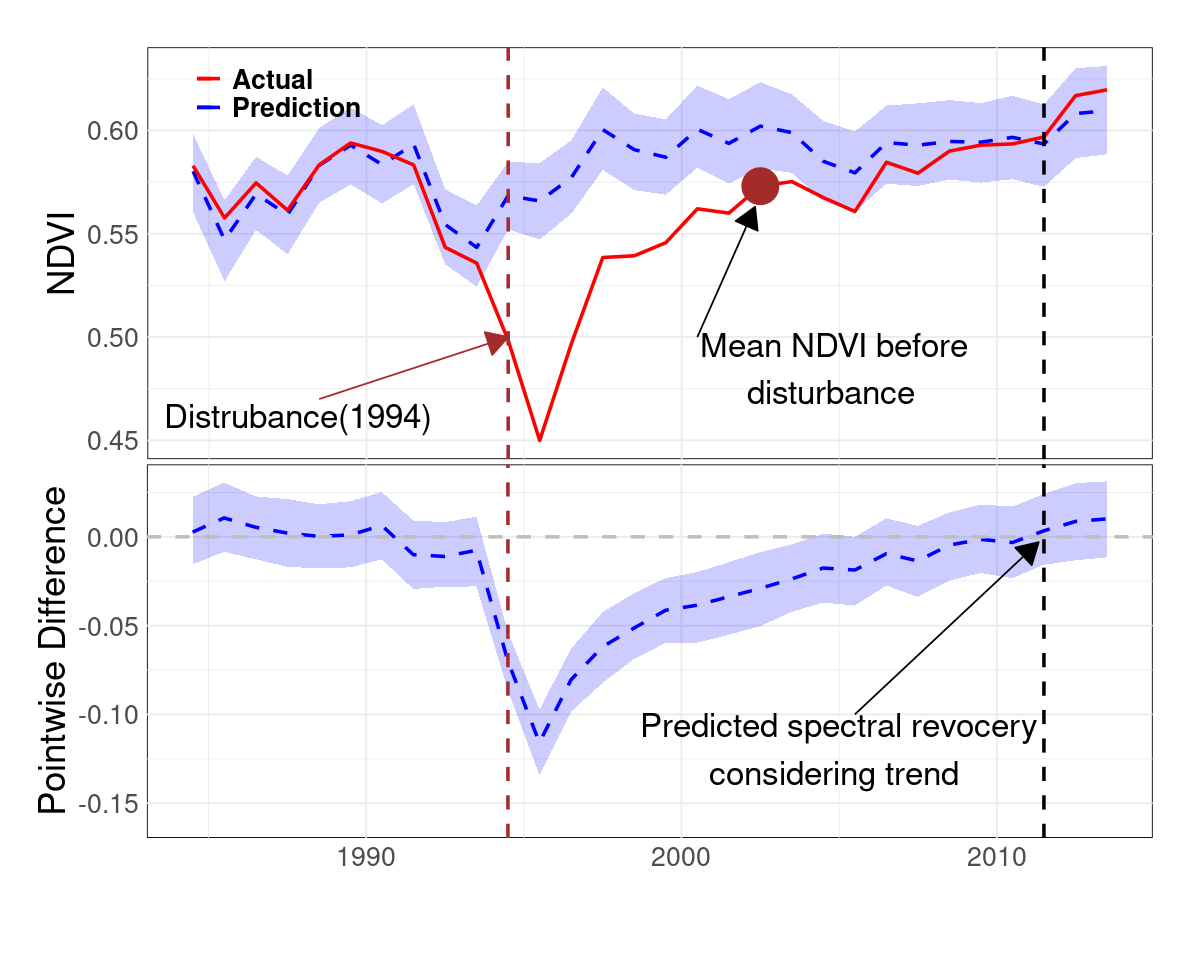

In [70]:
options(
  repr.plot.width = 10,     # Width of the plot
  repr.plot.height = 8    # Height of the plot
)
gg1 <- ggplot() +
  geom_line(aes(x = t, y = pred, color = "Prediction"), size = 1, linetype = "dashed") +
  geom_ribbon(aes(x = t, ymin = pred.lower, ymax = pred.upper, fill = "Prediction"), alpha = 0.2) +
  geom_line(aes(x = t, y = response, color = "Actual"), size = 1) +
  labs(
    x = "",
    y = "NDVI"
  ) +
  scale_color_manual(
    values = c("Prediction" = "blue", "Actual" = "red"),
    labels = c("Actual","Prediction")
  ) +
  scale_fill_manual(
    values = c("Prediction" = "blue"),
    guide = FALSE
  ) +
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white"),
    axis.text = element_text(size = 16),        # Font size for tick labels
    axis.text.x = element_blank(),
    axis.title = element_text(size = 22),
    legend.position = c(.13,.90),  # Move the legend to the bottom
    legend.background = element_rect(fill = "white", color = "black"),  # Legend background color and border
    legend.box = "horizontal",  # Arrange legend items horizontally,
    legend.text = element_text(size = 16,face="bold"),
    legend.title = element_blank(),
    plot.margin=unit(c(1,1,-0.5,1), "cm")
  ) 
  gg1 = gg1+theme(legend.background = element_blank())
  gg1 <- gg1 +
  geom_vline(xintercept = as.Date("1994-07-01"), linetype = "dashed", color = "brown",size=1) +
  geom_vline(xintercept = as.Date("2011-07-01"), linetype = "dashed", color = "black",size=1) +
  geom_segment(
    aes(x = as.Date("1988-07-01"), xend = as.Date("1994-07-01"), y = .47, yend = .5),
    arrow = arrow(type = "closed", length = unit(0.2, "inches")),
    lineend = "butt",
    color = "brown"
  ) +
  annotate("text", x = as.Date("1987-07-01"), y = .45, label = "Distrubance(1994)", vjust = -0.5, hjust = 0.46, color = "black",
  size=7,face="bold")+
  geom_segment(
  aes(x = as.Date("2000-07-01"), xend = as.Date("2002-05-01"), y = .5, yend = response[19]-0.01),
  arrow = arrow(type = "closed", length = unit(0.2, "inches")),
  lineend = "butt",
  color = "black"
  ) +
  annotate("text", x = as.Date("2004-07-01"), y = .45, label = "Mean NDVI before\n disturbance ", vjust = -0.5, hjust = 0.46, color = "black",
  size=7)

  gg1 = gg1+geom_point(aes(x = as.Date("2002-07-01"), y = response[19]),color = "brown",
  show.legend = FALSE, size = 8,stroke=2)
   

gg2 <- ggplot() +
  geom_line(aes(x=t,y = point.effect), color = "blue", size = 1,linetype="dashed") +
  geom_ribbon(aes(t,ymin=point.effect.lower,ymax=point.effect.upper),fill="blue",alpha=0.2)+
  # geom_line(aes(x=t,y = response), color = "red", size = 1) +
  labs(
    x = "",
    y = "Pointwise Difference"
  ) + theme_minimal() + theme(panel.background = element_rect(fill = "white")
  , axis.text = element_text(size = 16),        # Font size for tick labels
    axis.title = element_text(size = 22),plot.margin=unit(c(-.33,1,1,.8), "cm") )  # Remove gridlines
gg2 <- gg2 +
  geom_vline(xintercept = as.Date("1994-07-01"), linetype = "dashed", color = "brown",size=1)+
  geom_vline(xintercept = as.Date("2011-07-01"), linetype = "dashed", color = "black",size=1)+
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray",size=1) +
  geom_segment(
    aes(x = as.Date("2005-07-01"), xend = as.Date("2011-05-01"), y = -0.1, yend = -.003),
    arrow = arrow(type = "closed", length = unit(0.2, "inches")),
    lineend = "butt",
    color = "black"
  ) +
  annotate("text", x = as.Date("2004-07-01"), y = -.16, label = "Predicted spectral revocery\n considering trend ", vjust = -0.5, hjust = 0.46, color = "black",
  size=7)


combined_plot <- grid.arrange(gg1, gg2, nrow = 2)
combined_plot

Warning message in annotate("text", x = as.Date("1986-07-01"), y = 0.46, label = "LCC(1994)", :
“Ignoring unknown parameters: `face`”
Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

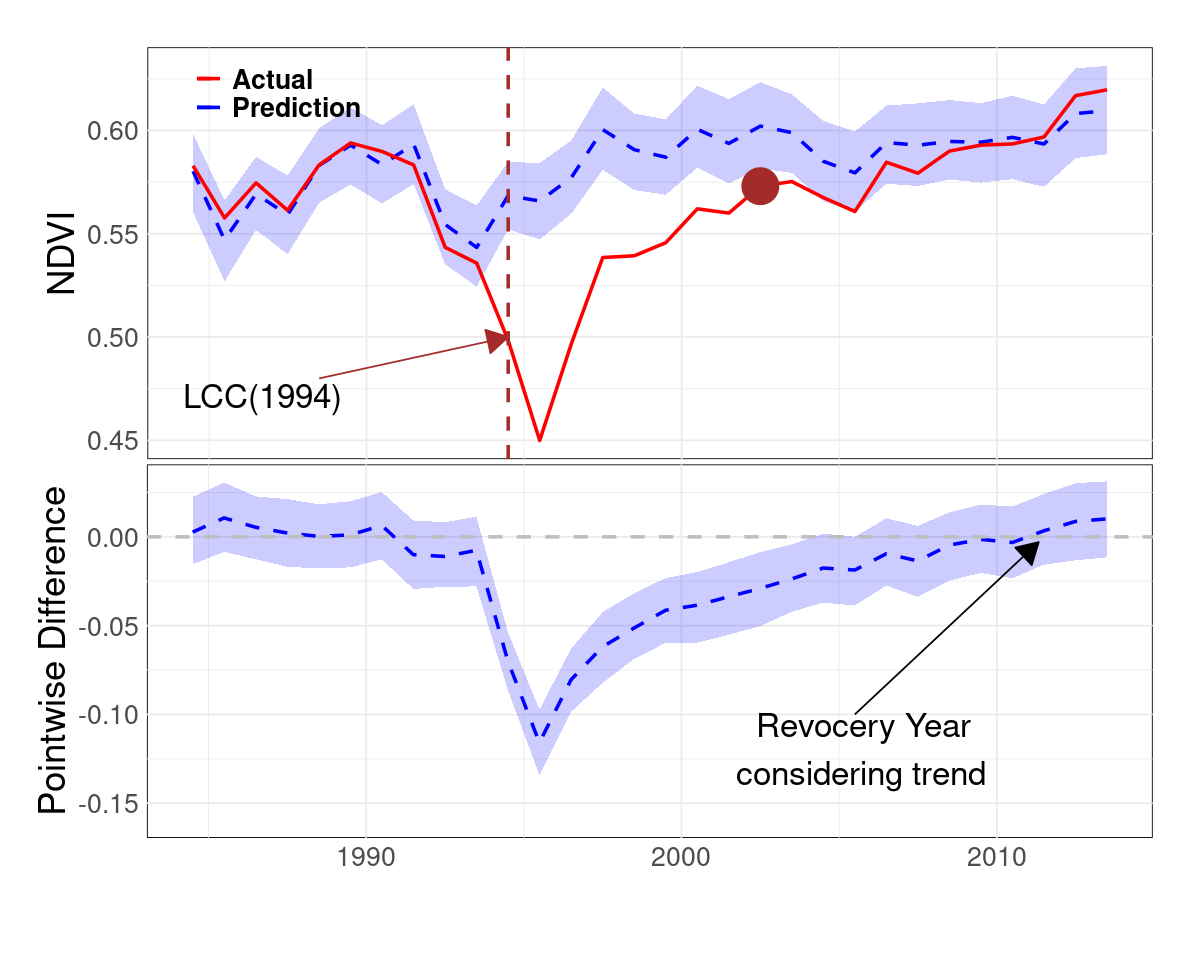

In [53]:
options(
  repr.plot.width = 10,     # Width of the plot
  repr.plot.height = 8    # Height of the plot
)
gg1 <- ggplot() +
  geom_line(aes(x = t, y = pred, color = "Prediction"), size = 1, linetype = "dashed") +
  geom_ribbon(aes(x = t, ymin = pred.lower, ymax = pred.upper, fill = "Prediction"), alpha = 0.2) +
  geom_line(aes(x = t, y = response, color = "Actual"), size = 1) +
  labs(
    x = "",
    y = "NDVI"
  ) +
  scale_color_manual(
    values = c("Prediction" = "blue", "Actual" = "red"),
    labels = c("Actual","Prediction")
  ) +
  scale_fill_manual(
    values = c("Prediction" = "blue"),
    guide = FALSE
  ) +
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white"),
    axis.text = element_text(size = 16),        # Font size for tick labels
    axis.text.x = element_blank(),
    axis.title = element_text(size = 22),
    legend.position = c(.13,.90),  # Move the legend to the bottom
    legend.background = element_rect(fill = "white", color = "black"),  # Legend background color and border
    legend.box = "horizontal",  # Arrange legend items horizontally,
    legend.text = element_text(size = 16,face="bold"),
    legend.title = element_blank(),
    plot.margin=unit(c(1,1,-0.5,1), "cm")
  ) 
  gg1 = gg1+theme(legend.background = element_blank())
  gg1 <- gg1 +
  geom_vline(xintercept = as.Date("1994-07-01"), linetype = "dashed", color = "brown",size=1) +
#   geom_vline(xintercept = as.Date("2011-07-01"), linetype = "dashed", color = "black",size=1) +
  geom_segment(
    aes(x = as.Date("1988-07-01"), xend = as.Date("1994-07-01"), y = .48, yend = .5),
    arrow = arrow(type = "closed", length = unit(0.2, "inches")),
    lineend = "butt",
    color = "brown"
  ) +
  annotate("text", x = as.Date("1986-07-01"), y = .46, label = "LCC(1994)", vjust = -0.5, hjust = 0.46, color = "black",
  size=7,face="bold")
  gg1 = gg1+geom_point(aes(x = as.Date("2002-07-01"), y = response[19]),color = "brown",
  show.legend = FALSE, size = 8,stroke=2)
   

gg2 <- ggplot() +
  geom_line(aes(x=t,y = point.effect), color = "blue", size = 1,linetype="dashed") +
  geom_ribbon(aes(t,ymin=point.effect.lower,ymax=point.effect.upper),fill="blue",alpha=0.2)+
  # geom_line(aes(x=t,y = response), color = "red", size = 1) +
  labs(
    x = "",
    y = "Pointwise Difference"
  ) + theme_minimal() + theme(panel.background = element_rect(fill = "white")
  , axis.text = element_text(size = 16),        # Font size for tick labels
    axis.title = element_text(size = 22),plot.margin=unit(c(-.33,1,1,.8), "cm") )  # Remove gridlines
gg2 <- gg2 +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray",size=1) +
  geom_segment(
    aes(x = as.Date("2005-07-01"), xend = as.Date("2011-05-01"), y = -0.1, yend = -.003),
    arrow = arrow(type = "closed", length = unit(0.2, "inches")),
    lineend = "butt",
    color = "black"
  ) +
  annotate("text", x = as.Date("2005-07-01"), y = -.16, label = "Revocery Year\nconsidering trend ", vjust = -0.5, hjust = 0.46, color = "black",
  size=7)


combined_plot <- grid.arrange(gg1, gg2, nrow = 2)
combined_plot

In [22]:
point.effect[20]

 2003-07-01 
-0.02370599 

Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.


TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


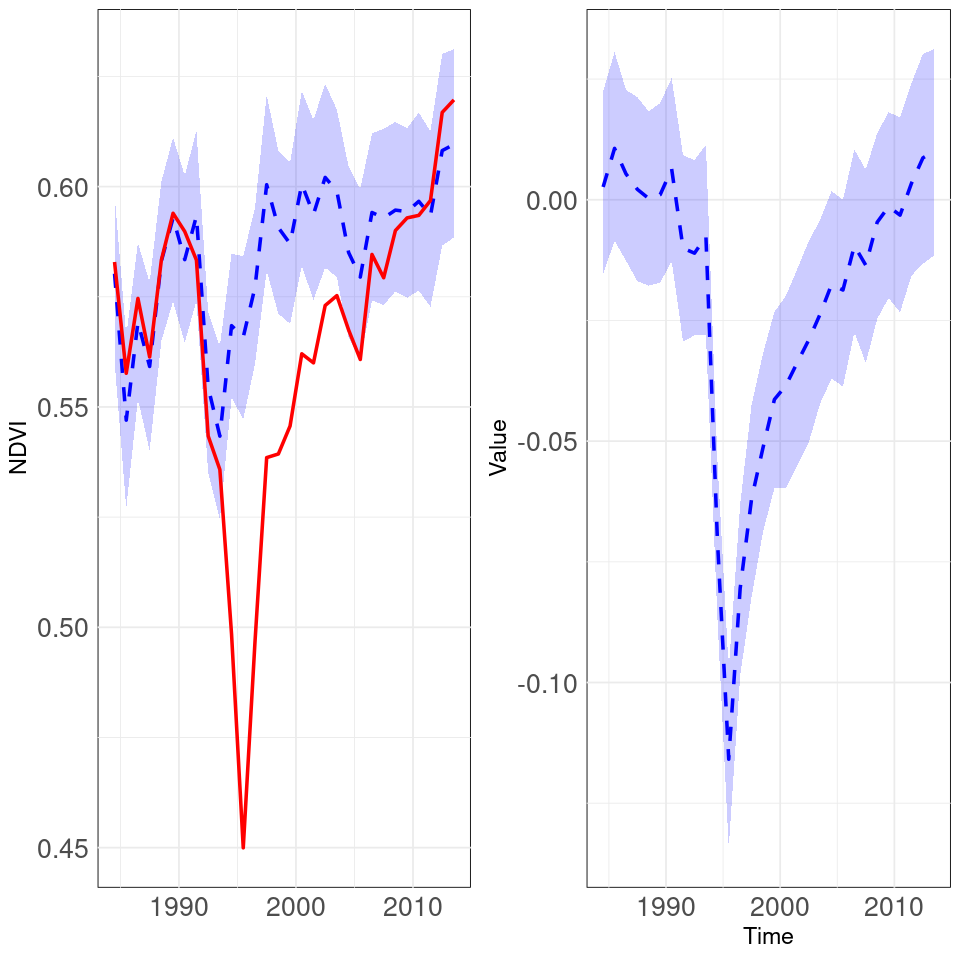

In [56]:
options(
  repr.plot.width = 8,     # Width of the plot
  repr.plot.height = 8    # Height of the plot
)

gg1 <- ggplot() +
  geom_line(aes(x = t, y = pred, color = "Prediction"), size = 1, linetype = "dashed") +
  geom_ribbon(aes(x = t, ymin = pred.lower, ymax = pred.upper, fill = "Prediction"), alpha = 0.2) +
  geom_line(aes(x = t, y = response, color = "Response"), size = 1) +
  labs(
    x = "",
    y = "NDVI"
  ) +
  scale_color_manual(
    values = c("Prediction" = "blue", "Response" = "red"),
    labels = c("Prediction", "Response")
  ) +
  scale_fill_manual(
    values = c("Prediction" = "blue"),
    guide = FALSE
  ) +
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white"),
    axis.text = element_text(size = 16),        # Font size for tick labels
    axis.title = element_text(size = 14),
    legend.position = "inside",  # Move the legend inside
    legend.background = element_rect(fill = "white", color = "black"),  # Legend background color and border
    legend.box = "horizontal"  # Arrange legend items horizontally
  )

gg2 <- ggplot() +
  geom_line(aes(x = t, y = point.effect), color = "blue", size = 1, linetype = "dashed") +
  geom_ribbon(aes(x = t, ymin = point.effect.lower, ymax = point.effect.upper), fill = "blue", alpha = 0.2) +
  labs(
    x = "Time",
    y = "Value"
  ) +
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white"),
    axis.text = element_text(size = 16),        # Font size for tick labels
    axis.title = element_text(size = 14),
    legend.position = "none"  # Remove the legend for gg2
  )

# Create two plots side by side
combined_plot <- grid.arrange(gg1, gg2, nrow = 1)

# Print the combined plot
print(combined_plot)

In [31]:
gg2 <- ggplot() +
  geom_line(aes(x=t,y = point.effect), color = "blue", size = 1,linetype="dashed") +
  geom_ribbon(aes(t,ymin=point.effect.lower,ymax=point.effect.upper),fill="blue",alpha=0.2)
gg2

Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.
ERROR while rich displaying an object: Error in `geom_ribbon()`:
! Problem while setting up geom.
ℹ Error occurred in the 2nd layer.
Caused by error in `compute_geom_1()`:
! `geom_ribbon()` requires the following missing aesthetics: ymin and
  ymax or y, xmin, and xmax

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, "

In [32]:
point.effect.lower

NULL

Posterior inference {CausalImpact}

                         Average            Cumulative      
Actual                   0.58               11.67           
Prediction (s.d.)        0.59 (0.0055)      11.82 (0.1097)  
95% CI                   [0.58, 0.6]        [11.60, 12.0]   
                                                            
Absolute effect (s.d.)   -0.0071 (0.0055)   -0.1424 (0.1097)
95% CI                   [-0.018, 0.0035]   [-0.361, 0.0706]
                                                            
Relative effect (s.d.)   -1.2% (0.92%)      -1.2% (0.92%)   
95% CI                   [-3%, 0.61%]       [-3%, 0.61%]    

Posterior tail-area probability p:   0.092
Posterior prob. of a causal effect:  91%

For more details, type: summary(impact, "report")

NULL


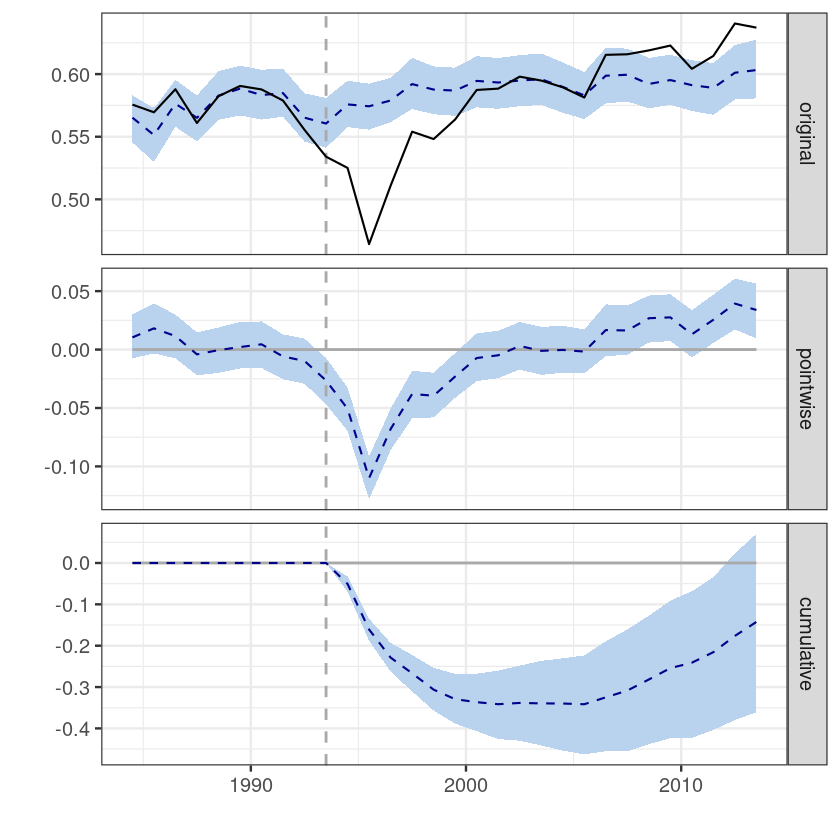

In [8]:
set.seed(15)
t <- seq.Date(as.Date("1984-07-01"), by = "years", length.out = 30)
data <- zoo(ndvi_1994_mean, t)
pre.period <- as.Date(c("1984-07-01", "1993-07-01"))
post.period <- as.Date(c("1994-07-01", "2013-07-01"))
impact <- CausalImpact(data, pre.period, post.period)
plot(impact)
print(summary(impact))

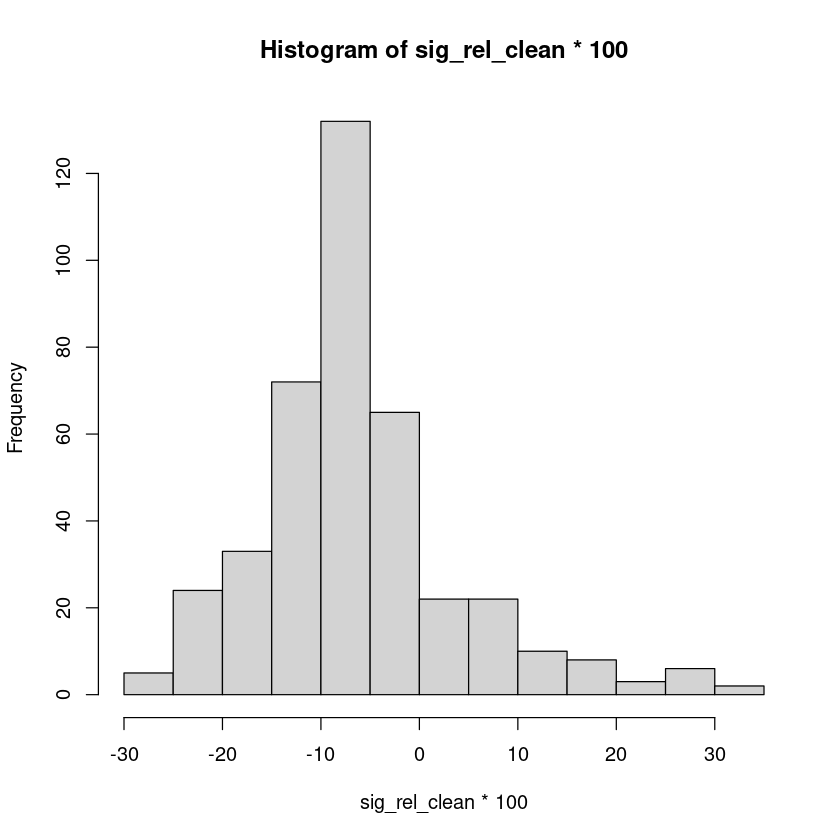

In [22]:
zscore <- function(data,std){
    (abs(data-mean(data))/sd(data))
}
res_na <- apply(res, 1, function(row) all(is.na(row)))
res_no_nan =res[res_na==FALSE,] 
sig = res_no_nan[,5]<0.01
sig_rel = res_no_nan[sig,4]
sig_rel_clean = sig_rel[(zscore(sig_rel)<3)]
hist(sig_rel_clean*100)